In [1]:
def get_list_stockname(df):
    cols = df['TICKER'].to_list()
    return set(cols)

In [2]:
def pd_readFile(path):
    pddata = pd.read_csv(path)
    return pddata

In [3]:
def convert_string_to_date(s):
    d = datetime.strptime(s,'%m/%d/%Y')
    return d

In [4]:
from datetime import datetime
import calendar
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [5]:
def refine_df(df, start_day, end_day):
    df['PRICE'] = round((df['LOW'] + df['HIGH'] + df['CLOSE'])/3,1)
    start_day = convert_string_to_date(start_day)
    end_day = convert_string_to_date(end_day)
    df['DATE'] = pd.to_datetime(df['DATE'],format='%m/%d/%Y')
    df = df[['TICKER','DATE','VOLUME','PRICE']]
    df = df[df['DATE']>start_day]
    df = df[df['DATE']<end_day]
    df = df[df['VOLUME'] != 0]
    return df

In [6]:
def create_dic_df(df, lStock):
    dic = {}
    for stock in lStock:
        dic[stock] = df[df['TICKER']==stock]
        dic[stock] = dic[stock].drop('TICKER', axis=1).reset_index(drop=True)
    return dic

In [7]:
def calculate_SMA(df, period, nameCol):
    df[nameCol] = 0
    price_col = df.columns.get_loc('PRICE')
    SMA_col = df.columns.get_loc(nameCol)
    
    for i in range(period,len(df)):
        df.iloc[i,SMA_col] = round((sum(df.iloc[i-period:i,price_col])/period),1)
        
    df = df.reset_index(drop=True)
    return df

In [8]:
def calculate_EMA(df, period, nameCol):
    df[nameCol] = 0
    alpha = 2/(period+1)
    price_col = df.columns.get_loc('PRICE')
    EMA_col = df.columns.get_loc(nameCol)
    initialEMA = sum(df.iloc[0:period,price_col])/period
    df.iloc[period,EMA_col] = initialEMA
    
    for i in range(period+1, len(df)):
        df.iloc[i,EMA_col] = round(alpha*(df.iloc[i,price_col]-df.iloc[i-1,EMA_col])+df.iloc[i-1,EMA_col],4)
        
    return df

In [9]:
def calculater_MACD(df, period, EMAs_name_col, EMAl_name_col, nameCol):
    df[nameCol] = 0
    MACD_col = df.columns.get_loc(nameCol)
    EMAs_col = df.columns.get_loc(EMAs_name_col)
    EMAl_col = df.columns.get_loc(EMAl_name_col)
    
    for i in range(period,len(df)):
        df.iloc[i,MACD_col] = df.iloc[i,EMAs_col] - df.iloc[i,EMAl_col]
    
    return df

In [10]:
def rsi_fo(val):
    return 100-100*(1/(1+val))

In [11]:
def calculate_MFI(df, period):
    df['RAW_MONEY'] = 0
    df['POS_MONEY'] = 0
    df['NEG_MONEY'] = 0
    df['SUM_POS_MONEY'] = 0
    df['SUM_NEG_MONEY'] = 0
    df['MONEY_RATIO'] = 0
    df['MFI'] = 0
    price_col = df.columns.get_loc('PRICE')
    volume_col = df.columns.get_loc('VOLUME')
    raw_money_col = df.columns.get_loc('RAW_MONEY')
    pos_money_col = df.columns.get_loc('POS_MONEY')
    neg_money_col = df.columns.get_loc('NEG_MONEY')
    sum_pos_money_col = df.columns.get_loc('SUM_POS_MONEY')
    sum_neg_money_col = df.columns.get_loc('SUM_NEG_MONEY')
    money_ratio_col = df.columns.get_loc('MONEY_RATIO')
    mfi_col = df.columns.get_loc('MFI')
    # 1 period
    for i in range(1,len(df)):
        df.iloc[i,raw_money_col] = df.iloc[i,price_col]*df.iloc[i,volume_col]
        if df.iloc[i,price_col]>df.iloc[i-1,price_col]:
            df.iloc[i,pos_money_col] = df.iloc[i,raw_money_col]
            df.iloc[i,neg_money_col] = 0
        elif df.iloc[i,price_col]<df.iloc[i-1,price_col]:
            df.iloc[i,pos_money_col] = 0
            df.iloc[i,neg_money_col] = df.iloc[i,raw_money_col]
    # n period
    for i in range(period,len(df)):
        sum_pos_period = sum([df.iloc[i,pos_money_col] for i in range(i-period+1,i+1)])
        sum_neg_preiod = sum([df.iloc[i,neg_money_col] for i in range(i-period+1,i+1)])
        df.iloc[i,sum_pos_money_col] = sum_pos_period
        df.iloc[i,sum_neg_money_col] = sum_neg_preiod
        if sum_neg_preiod!=0:
            df.iloc[i,money_ratio_col] = round(sum_pos_period/sum_neg_preiod,3)
            df.iloc[i,mfi_col] = round(rsi_fo(df.iloc[i,money_ratio_col]),3)

    return df    

In [12]:
def shorten_table(df,list_name_col):
    for name in list_name_col:
        df = df.drop(name, axis=1)
    return df

In [13]:
def calculate_RSI(df, period):
    df['GAIN'] = 0
    df['LOSS'] = 0
    df['AVG_GAIN'] = 0
    df['AVG_LOSS'] = 0
    df['RS'] = 0
    df['RSI'] = 0
    gain_col = df.columns.get_loc('GAIN')
    loss_col = df.columns.get_loc('LOSS')
    price_col = df.columns.get_loc('PRICE')
    avg_gain_col = df.columns.get_loc('AVG_GAIN')
    avg_loss_col = df.columns.get_loc('AVG_LOSS')
    rs_col = df.columns.get_loc('RS')
    rsi_col = df.columns.get_loc('RSI')
    # 14days of Gain & Loss
    sum_gain = 0
    sum_loss = 0
    for i in range(1,len(df)):
        to = df.iloc[i,price_col]
        ye = df.iloc[i-1,price_col]
        if to>ye:
            df.iloc[i,gain_col] = to-ye
            df.iloc[i,loss_col] = 0
        else:
            df.iloc[i,gain_col] = 0
            df.iloc[i,loss_col] = ye-to
    # Initial Avg Gain
    sum_gain = sum([df.iloc[i,gain_col] for i in range(1,period+1)])
    sum_loss = sum([df.iloc[i,loss_col] for i in range(1,period+1)])
    avg_gain = sum_gain/period
    avg_loss = sum_loss/period
    df.iloc[period,avg_gain_col] = avg_gain
    df.iloc[period,avg_loss_col] = avg_loss
    df.iloc[period,rs_col] = avg_gain/avg_loss
    df.iloc[period,rsi_col] = rsi_fo(df.iloc[period,rs_col])
    # RSI
    for i in range(period+1, len(df)):
        df.iloc[i,avg_gain_col] = round((df.iloc[i-1,avg_gain_col]*13 + df.iloc[i,gain_col])/14,3)
        df.iloc[i,avg_loss_col] = round((df.iloc[i-1,avg_loss_col]*13 + df.iloc[i,loss_col])/14,3)
        df.iloc[i,rs_col] = round(df.iloc[i,avg_gain_col]/df.iloc[i,avg_loss_col],3)
        df.iloc[i,rsi_col] = round(rsi_fo(df.iloc[i,rs_col]),3)
    
    return df

In [14]:
def dc(df,min_index, emasName, emalName, macdName):
    df['TRADE'] = None
    emas_col = df.columns.get_loc(emasName)
    emal_col = df.columns.get_loc(emalName)
    macd_col = df.columns.get_loc(macdName)
    rsi_col = df.columns.get_loc('RSI')
    mfi_col = df.columns.get_loc('MFI')
    trade_col = df.columns.get_loc('TRADE')
    trade = ''
    for i in range(min_index+1,len(df)):
        if (df.iloc[i,emas_col]>=df.iloc[i,emal_col])&(df.iloc[i-1,emas_col]<df.iloc[i-1,emal_col]):
            trade = 'buy'
        elif (df.iloc[i,emas_col]<=df.iloc[i,emal_col])&(df.iloc[i-1,emas_col]>df.iloc[i-1,emal_col]):
            trade = 'sell'
        elif (df.iloc[i,macd_col]>=df.iloc[i,emas_col]) & (df.iloc[i-1,macd_col]<df.iloc[i,emas_col]):
            trade = 'buy'
        elif (df.iloc[i,macd_col]<=df.iloc[i,emas_col]) & (df.iloc[i-1,macd_col]>df.iloc[i,emas_col]):
            trade = 'sell'
        elif (df.iloc[i,rsi_col]<=30) & (df.iloc[i-1,rsi_col]>30):
            trade = 'buy'
        elif (df.iloc[i,rsi_col]>=70) & (df.iloc[i-1,rsi_col]>70):
            trade = 'sell'
        elif (df.iloc[i,mfi_col]<=20) & (df.iloc[i-1,mfi_col]>20):
            trade = 'buy'
        elif (df.iloc[i,mfi_col]>=80) & (df.iloc[i-1,mfi_col]<80):
            trade = 'sell'
        else:
            trade = 'hold'
        # rule realated to SAR
        ### ...
        df.iloc[i,trade_col] = trade
    return df

In [15]:
def profitability(period, df, min_index):
    max_index = len(df) - period
    df['PROFIT'] = 0
    price_col = df.columns.get_loc('PRICE')
    profit_col = df.columns.get_loc('PROFIT')
    for i in range(min_index+1,max_index):
        price_today = df.iloc[i,price_col]
        sum_price_future = sum(df[i+1:i+period].PRICE)
        avg_price_future = sum_price_future/period
        df.iloc[i,profit_col] = avg_price_future - price_today
#         print('{0} -- {1}'.format(price_today, avg_price_future))

    return df

In [16]:
def profit_index(df, min_index):
    n_trades = len(df) - min_index - 1
    n_profits = 0
    n_loss = 0
    num_profits = 0
    num_loss = 0
    no_loss_no_profit = 0
    trade_col = df.columns.get_loc('TRADE')
    profit_col = df.columns.get_loc('PROFIT')
    for i in range(min_index+1, len(df)):
        trade = df.iloc[i,trade_col]
        profit = df.iloc[i,profit_col]
        if (trade == 'buy'):
            if (profit>0):
                n_profits = n_profits + profit
                num_profits = num_profits + 1
            elif profit<0:
                n_loss = n_loss + profit
                num_loss = num_loss + 1
        elif (trade == 'sell'):
            if profit<0:
                n_profits = n_profits - profit
                num_profits = num_profits + 1
            elif profit>0:
                n_loss = n_loss - profit
                num_loss = num_loss + 1
        elif (trade == 'hold'):
            if profit>0:
                n_profits = n_profits + profit
                num_profits = num_profits + 1
            elif profit < 0:
                n_loss = n_loss + profit
                num_loss = num_loss + 1
  
    avg_loss = n_loss/num_loss
    avg_profit = n_profits/num_profits
    alpha = n_profits/n_trades - 1/(1+ avg_profit/avg_loss)
    print('n loss: {0}, n profit: {1}, num loss: {2}, num profit: {3}'.format(n_loss, n_profits, num_loss, num_profits))
    print('avg loss: {0}, avg profit: {1}'.format(avg_loss, avg_profit))
    
    return alpha

In [27]:
def visualizeData(df, lst_col, title):
    df = df[lst_col]
    df.plot(x='DATE')
    plt.title(title, fontsize=20, color='red')
    plt.rcParams['figure.figsize'] = [10,6]
    plt.show()
    
    return 1

In [18]:
def composition_indicator_calculator(pri_df, min_index):
    emas_name = 'EMA_12'
    emal_name = 'EMA_24'
    macd_name = 'MACD_12_24'
    df = pri_df
#     df = calculate_SMA(df,10,'SMA_10')
    df = calculate_EMA(df,12,emas_name)
    df = calculate_EMA(df,24,emal_name)
    df = calculater_MACD(df,24,emas_name,emal_name,macd_name)
    df = calculate_MFI(df, 12)
    df = calculate_RSI(df, 24)
    df = dc(df, min_index, emas_name, emal_name, macd_name)
    df = profitability(90, df, min_index)
    return df 

In [19]:
# Read file csv
path = 'HOSE5ys.csv'
df = pd_readFile(path)

# constant
start_day = '09/05/2015'
end_day = '05/05/2017'
df = refine_df(df, start_day, end_day)
lStock = get_list_stockname(df)
dic = {}
dic = create_dic_df(df, lStock)
# dic['AAA'] = calculate_SMA(dic['AAA'],10,'SMA_10')
list_col_to_del = ['POS_MONEY','NEG_MONEY','MONEY_RATIO','GAIN','LOSS','AVG_GAIN','AVG_LOSS']
min_index = 24

# Real calculation
df = dic['AAA']
df = composition_indicator_calculator(df, min_index)

# prune df
df = shorten_table(df,list_col_to_del)

# evaluate profitability
profit = profit_index(df, min_index)

n loss: -793.8922222222213, n profit: 508.03111111111076, num loss: 173, num profit: 121
avg loss: -4.588972382787406, avg profit: 4.198604224058767


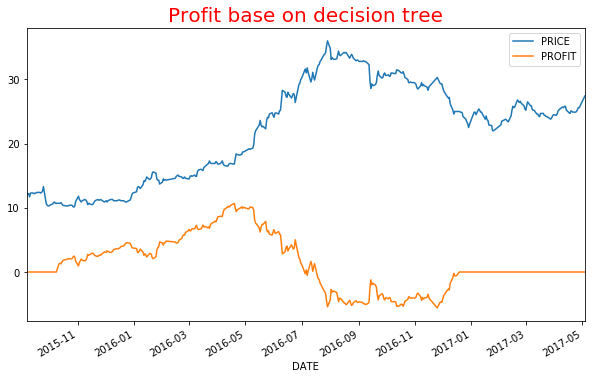

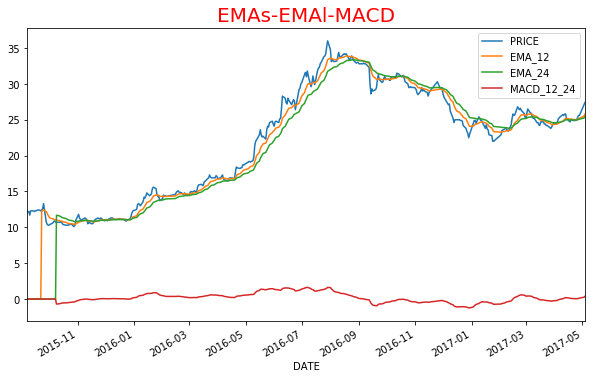

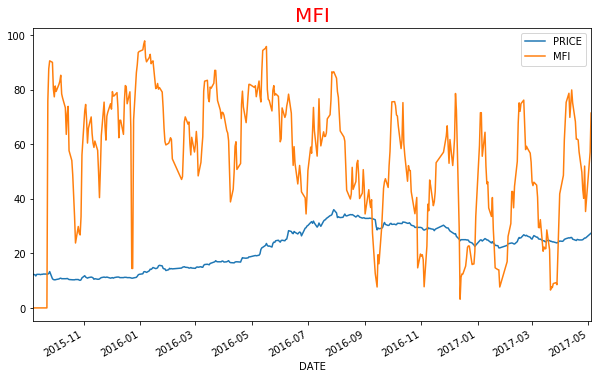

1

In [32]:
# Demonstrate indicators
lst_col = ['DATE','PRICE','PROFIT']
title = "Profit base on decision tree"
visualizeData(df, lst_col, title)

lst_col = ['DATE','PRICE','EMA_12', 'EMA_24', 'MACD_12_24']
title = "EMAs-EMAl-MACD"
visualizeData(df, lst_col, title)

lst_col = ['DATE','PRICE','MFI']
title = "MFI"
visualizeData(df, lst_col, title)

In [30]:
df

,DATE,VOLUME,PRICE,EMA_12,EMA_24,MACD_12_24,RAW_MONEY,SUM_POS_MONEY,SUM_NEG_MONEY,MFI,RS,RSI,TRADE,PROFIT
0,2015-09-07,307300,12.3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
1,2015-09-08,157800,12.2,0.000000,0.000000,0.000000,1925160.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
2,2015-09-09,104000,12.2,0.000000,0.000000,0.000000,1268800.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
3,2015-09-10,69500,11.7,0.000000,0.000000,0.000000,813150.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
4,2015-09-11,550200,12.3,0.000000,0.000000,0.000000,6767460.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
5,2015-09-14,368700,12.3,0.000000,0.000000,0.000000,4535010.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
6,2015-09-15,87000,12.2,0.000000,0.000000,0.000000,1061400.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
7,2015-09-16,358800,12.3,0.000000,0.000000,0.000000,4413240.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
8,2015-09-17,328700,12.3,0.000000,0.000000,0.000000,4043010.0,0.0,0.0,0.000,0.000,0.000,None,0.000000
9,2015-09-18,64500,12.4,0.000000,0.000000,0.000000,799800.0,0.0,0.0,0.000,0.000,0.000,None,0.000000


In [55]:
def visualizeData(df):
    df.plot(x='DATE',y='PRICE')
    return 1

KeyError: 'DATE'

<Figure size 432x288 with 0 Axes>

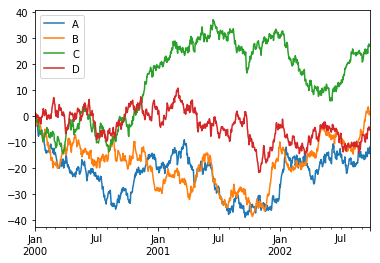

In [56]:
ts = pd.Series(np.random.randn(1000),index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()
df = pd.DataFrame(np.random.randn(1000, 4),index=ts.index, columns=list('ABCD'))
df = df.cumsum()
plt.figure()
df.plot()
visualizeData(df)

In [58]:
type(df)

pandas.core.frame.DataFrame

In [19]:
#aaa = data.filter(data.TICKER == 'AAA')
# for i in lStock:
#     print(len(dic[i]))
# dic['AAA'] = df[df['TICKER']=='AAA']

k = df
print(profit)
k[50:199]

NameError: name 'profit' is not defined

In [37]:
# peri = 10
# k['SMA'] = 0
# k.iloc[peri:,4] = sum(k.iloc[peri-10:peri,3])
# len(k)
# for i in range(peri,len(k)):
#     k.iloc[i,4] = round((sum(k.iloc[i-10:i,3])/peri),1)

In [38]:
k

,DATE,VOLUME,PRICE,EMA_12,EMA_24,MACD_12_24,RAW_MONEY,SUM_POS_MONEY,SUM_NEG_MONEY,MFI,RS,RSI,TRADE
0,2015-09-07,307300,12.3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.000,0.000,None
1,2015-09-08,157800,12.2,0.000000,0.000000,0.000000,1925160.0,0.0,0.0,0.000,0.000,0.000,None
2,2015-09-09,104000,12.2,0.000000,0.000000,0.000000,1268800.0,0.0,0.0,0.000,0.000,0.000,None
3,2015-09-10,69500,11.7,0.000000,0.000000,0.000000,813150.0,0.0,0.0,0.000,0.000,0.000,None
4,2015-09-11,550200,12.3,0.000000,0.000000,0.000000,6767460.0,0.0,0.0,0.000,0.000,0.000,None
5,2015-09-14,368700,12.3,0.000000,0.000000,0.000000,4535010.0,0.0,0.0,0.000,0.000,0.000,None
6,2015-09-15,87000,12.2,0.000000,0.000000,0.000000,1061400.0,0.0,0.0,0.000,0.000,0.000,None
7,2015-09-16,358800,12.3,0.000000,0.000000,0.000000,4413240.0,0.0,0.0,0.000,0.000,0.000,None
8,2015-09-17,328700,12.3,0.000000,0.000000,0.000000,4043010.0,0.0,0.0,0.000,0.000,0.000,None
9,2015-09-18,64500,12.4,0.000000,0.000000,0.000000,799800.0,0.0,0.0,0.000,0.000,0.000,None


In [ ]:
k

In [51]:
df_AAA = df[df.TICKER == 'DAG']
#airport_freq[airport_freq.airport_ident == 'KLAX'].sort_values('type')
groups = df.groupby('TICKER')

#create a dictionary of dataframes, one for each cluster
c_dict = {k: pd.DataFrame(v) for k, v in groups.groups.iteritems() }
    

AttributeError: 'dict' object has no attribute 'iteritems'

In [52]:
for v in dic.items():
    print(v)

In [73]:
groups.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,PRICE
0,AAA,4/4/2014,23.2,23.4,22.5,22.8,494300,22.9
1,AAA,4/7/2014,23.2,23.3,22.8,23.0,156300,23.0
2,AAA,4/8/2014,23.0,24.3,23.0,24.0,490200,23.8
3,AAA,4/10/2014,23.0,24.0,23.0,23.4,201100,23.5
4,AAA,4/11/2014,23.5,23.5,22.9,23.0,383100,23.1
1167,AAM,4/4/2014,15.5,15.7,15.5,15.6,404,15.6
1168,AAM,4/7/2014,15.9,15.9,15.9,15.9,201,15.9
1169,AAM,4/8/2014,15.9,15.9,15.9,15.9,36,15.9
1170,AAM,4/10/2014,15.7,16.0,15.7,16.0,416,15.9
1171,AAM,4/11/2014,15.5,15.8,15.5,15.8,800,15.7


In [63]:
bbb = aaa.filter(aaa.DATE>='3/3/2015')

In [55]:
k = datetime.strptime('4/4/2014', '%m/%d/%Y')

In [54]:
aaa.printSchema()

root
 |-- TICKER: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- OPEN: string (nullable = true)
 |-- HIGH: string (nullable = true)
 |-- LOW: string (nullable = true)
 |-- CLOSE: string (nullable = true)
 |-- VOLUME: string (nullable = true)



In [39]:
s1 = '04/5/1995'
s2 = '04/30/1995'
d1 = convert_string_to_date(s1)
d2 = convert_string_to_date(s2)
if (d1>d2):
    print('>')
else:
    print('no')

no


In [6]:
# Suspect consecutiveness of stock
tempDic = {}
trackDate = {}
for st in lNameStock:
    for i in range(len(lData)):
        #if (continity[st] < 673 and lData[i].__getitem__('TICKER')==st):
        if lData[i].__getitem__('TICKER')==st:
            if flag[st] == 1:
                St_t = datetime.strptime(lData[i].__getitem__('DATE'),'%m/%d/%Y')
                #print(st, St_t, lData[i].__getitem__('OPEN'))
                Weekday_t = calendar.day_name[St_t.weekday()]
                if ((St_t-St_pre).days == 1) or ((St_t-St_pre).days == 3 and Weekday_t == 'Monday'):
                    continity[st] = continity[st]+1
                    #print(st, continity[st], St_t.strftime("%d %m %Y "))
                else:
                    continity[st] = 0
                    tempDic['DateBegin'] = St_t.strftime("%d %m %Y")
                St_pre = St_t
            else:
                St_pre = datetime.strptime(lData[i].__getitem__('DATE'),'%m/%d/%Y')
                tempDic['DateBegin'] = St_pre.strftime("%d %m %Y ")
                flag[st] = 1
                continity[st] = 1
        else:
            tempDic['DateEnd'] = St_pre.strftime("%d %m %Y ")
            trackDate[st] = tempDic
    

['AAA',
 'AAM',
 'ABT',
 'ACC',
 'ACL',
 'ADS',
 'AGF',
 'AGM',
 'AGR',
 'AMD',
 'ANV',
 'APC',
 'APG',
 'ASM',
 'ASP',
 'AST',
 'ATG',
 'BBC',
 'BCE',
 'BCG',
 'BFC',
 'BHN',
 'BIC',
 'BID',
 'BMC',
 'BMI',
 'BMP',
 'BRC',
 'BSI',
 'BTP',
 'BTT',
 'BVH',
 'BWE',
 'C32',
 'C47',
 'CAV',
 'CCI',
 'CCL',
 'CDC',
 'CEE',
 'CHP',
 'CIG',
 'CII',
 'CLC',
 'CLG',
 'CLL',
 'CLW',
 'CMG',
 'CMT',
 'CMV',
 'CMX',
 'CNG',
 'COM',
 'CRC',
 'CRE',
 'CSM',
 'CSV',
 'CTD',
 'CTF',
 'CTG',
 'CTI',
 'CTS',
 'CVT',
 'D2D',
 'DAG']

In [9]:
trackDate

{'AAA': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'AAM': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'ABT': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'ACC': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'ACL': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'ADS': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'AGF': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'AGM': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'AGR': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'AMD': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'ANV': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'APC': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'APG': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'ASM': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'ASP': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2019 '},
 'AST': {'DateBegin': '05 05 2014', 'DateEnd': '02 04 2

In [46]:
continity['AAA']

36